In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os
from astroNN.nn.layers import MCDropout
import math
from matplotlib.ticker import FormatStrFormatter

Reading JLA covariance matrix and examinate the min, max and mean from it. 

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5')
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov))
# z_redshift, dist

-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31)


In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

Text(0.5, 1.0, 'Original matrix scaled and extended')

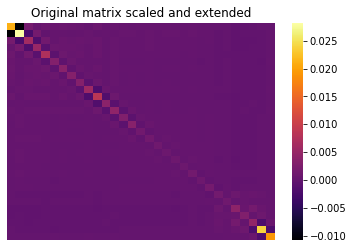

In [4]:
sns.heatmap(syscov, 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix scaled and extended')

In [5]:
def matrixGenerator(omatrix, nmatrix, freq_original=100):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        print("Generating matrix {}".format(it), end='\r')
        if it % freq_original ==0:
            m = omatrix
        else:
            m = P@omatrix@P.T
       
        mag = matrixMag(omatrix)
        
        matrixset[it, :, :] = m + np.multiply(0.1*np.random.rand(nsize,nsize), mag)
        

    return matrixset



def matrixGenerator2(omatrix, nmatrix, noisefactor=0.5):
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        print("Generating matrix {}".format(it+1), end='\r')
        mag = matrixMag(omatrix)

        matrixset[it, :, :] = omatrix + np.multiply(noisefactor*np.random.rand(nsize,nsize), mag)
        
    return matrixset
        
def matrixGenerator3(omatrix, nmatrix, noise_factor=0.05):
    D, P = sp.linalg.eigh(syscov)
    D = np.diag(D)
#     maxval_eigen = np.max(P)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        print("Generating matrix {}".format(it), end='\r')
        for row in range(nsize):
            for col in range(nsize):
                el = P[row, col]
                matrixset[it, row, col] = np.random.normal(loc=el, scale=0.5*10**orderMag(el))
#         matrixset[it, :, :nsize] = P + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=P.shape) 
        
    return matrixset, D
    


In [6]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix

In [7]:
def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    mshape = np.shape(matrix)
    magMatrix = np.zeros(mshape)
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = 10**orderMag(matrix[row, col])
    return magMatrix            

In [8]:
numMatrix = 1000
# covset, D = matrixGenerator3(syscov, numMatrix)
covset = matrixGenerator2(syscov, numMatrix, noisefactor=2)

<AxesSubplot:>

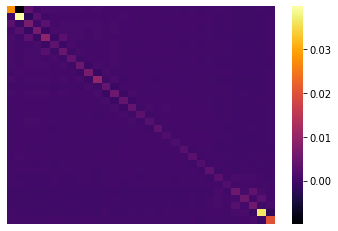

In [9]:
# sns.heatmap(scalercov.inverse_transform(covset[10, :, :]@D@covset[10, :, :].T), 
# sns.heatmap(covset[1, :, :]@D@covset[1,:,:].T, 
sns.heatmap(covset[11, :, :],             
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', cbar=True,
            robust=False)


In [10]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
# covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)
# np.shape(covset_noise_test)

(1000, 31, 31)


Text(0.5, 1.0, 'TEST MATRIX')

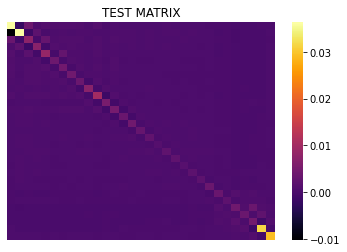

In [11]:
sns.heatmap(covset_test[0,:,:], 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

# Start design of ConVAE

In [71]:
# Sampling class from https://github.com/keras-team/keras-io

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [72]:
input_shape = (31, 31, 1)
latent_dim = 1


inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
# ((top_pad, bottom_pad), (left_pad, right_pad))
# x = layers.ZeroPadding2D(((5,4),(5,4)))(inputs)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
shape_enc = K.int_shape(x)
x = layers.Flatten()(x)
# x = layers.Dense(500, activation='relu')(x)
x = layers.Dense(50, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])
z = Sampling()([z_mean, z_log_var])

# z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 31, 31, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 8, 8, 64)     36928       conv2d_7[0][0]                   
____________________________________________________________________________________________

In [47]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(50, activation='relu')(latent_inputs)
# x = layers.Dense(500, activation='relu')(x)
x = layers.Dense(shape_enc[1] * shape_enc[2] * shape_enc[3], activation='relu')(x)
x = layers.Reshape((shape_enc[1], shape_enc[2], shape_enc[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=1, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=1, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x= layers.Conv2DTranspose(1, 3, activation='linear', strides=2, padding='same')(x)
# outputs = layers.Cropping2D(cropping=((5, 4), (5, 4)))(x)
outputs = layers.Cropping2D(cropping=((1, 0), (1, 0)))(x)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              208896    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 32)        1846

In [48]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_conv')
vae.summary()

Model: "vae_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 31, 31, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 1), (None, 1), (N 260696    
_________________________________________________________________
decoder (Functional)         (None, 31, 31, 1)         301605    
Total params: 562,301
Trainable params: 562,301
Non-trainable params: 0
_________________________________________________________________


In [73]:
# VAE class from https://github.com/keras-team/keras-io
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
#                     tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    tf.keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [74]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

covmatrixset = np.concatenate([covset_train, covset_train], axis=0)
covmatrixset = np.expand_dims(covmatrixset, -1).astype("float32")



### TRAINING

In [75]:
vae_train = vae.fit(covmatrixset, epochs=30, batch_size=128, verbose=2)                  

Epoch 1/30
13/13 - 1s - loss: 5.0863e-04 - reconstruction_loss: 4.8319e-04 - kl_loss: 2.5439e-05
Epoch 2/30
13/13 - 1s - loss: 2.9952e-04 - reconstruction_loss: 2.9869e-04 - kl_loss: 8.2924e-07
Epoch 3/30
13/13 - 1s - loss: 2.6082e-04 - reconstruction_loss: 2.6058e-04 - kl_loss: 2.3928e-07
Epoch 4/30
13/13 - 1s - loss: 2.5188e-04 - reconstruction_loss: 2.5185e-04 - kl_loss: 2.7044e-08
Epoch 5/30
13/13 - 1s - loss: 2.4922e-04 - reconstruction_loss: 2.4922e-04 - kl_loss: 2.8656e-09
Epoch 6/30
13/13 - 1s - loss: 2.4571e-04 - reconstruction_loss: 2.4571e-04 - kl_loss: 2.3283e-09
Epoch 7/30
13/13 - 1s - loss: 2.4534e-04 - reconstruction_loss: 2.4534e-04 - kl_loss: 5.3730e-10
Epoch 8/30
13/13 - 1s - loss: 2.4549e-04 - reconstruction_loss: 2.4549e-04 - kl_loss: 5.3730e-10
Epoch 9/30
13/13 - 1s - loss: 2.4650e-04 - reconstruction_loss: 2.4650e-04 - kl_loss: 3.5820e-10
Epoch 10/30
13/13 - 1s - loss: 2.4357e-04 - reconstruction_loss: 2.4357e-04 - kl_loss: 0.0000e+00
Epoch 11/30
13/13 - 1s - loss

(array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

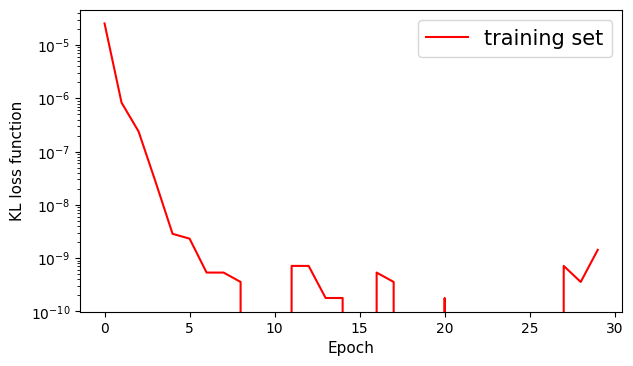

In [76]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(vae_train.history['kl_loss'], color='r', )

plt.yscale("log")
plt.ylabel('KL loss function', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([0.0002 , 0.00025, 0.0003 , 0.00035, 0.0004 , 0.00045, 0.0005 ,
        0.00055]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

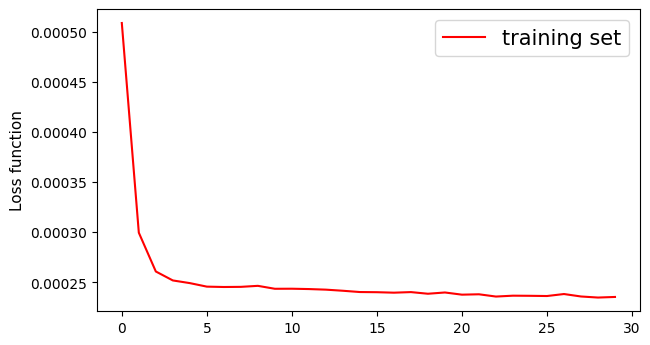

In [77]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(vae_train.history['loss'], color='r', )

plt.ylabel('Loss function', fontsize=11)
plt.xlabel('', fontsize=11)
plt.legend(['training set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Visualize the latent space

In [78]:
x_test_encoded = encoder.predict(covset_test)
z_mean = x_test_encoded[0]
z_std = x_test_encoded[1]
z_latent = x_test_encoded[2]

print(type(x_test_encoded))
print(np.shape(x_test_encoded))
print(np.shape(x_test_encoded[0]))
print(np.shape(x_test_encoded[1]))
print(np.shape(x_test_encoded[2]))

<class 'list'>
(3, 200, 1)
(200, 1)
(200, 1)
(200, 1)


## The z_mean and z_std vectors

<Figure size 360x360 with 0 Axes>

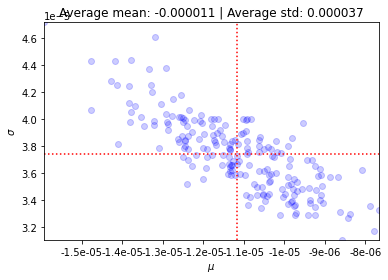

In [79]:
plt.figure(figsize=(5, 5))
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.scatter(z_mean, z_std, marker='o', c='blue', alpha=0.2)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
meanmean = np.mean(z_mean)
meanstd = np.mean(z_std)
plt.title('Average mean: {:.6f} | Average std: {:.6f}'.format(meanmean, meanstd))
xmin = np.min(z_mean)#-0.1*10**orderMag(meanmean)
xmax = np.max(z_mean)#+0.1*10**orderMag(meanmean)
ymin = np.min(z_std)#-0.1*10**orderMag(meanmean)
ymax = np.max(z_std)#+0.1*10**orderMag(meanmean)
# ax.xaxis.set_ticks(np.arange(xmin, xmax, 0.000001))

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.xticks()
plt.hlines(meanstd, xmin, xmax, colors='r', linestyles='dotted')
plt.vlines(meanmean, ymin, ymax, colors='r', linestyles='dotted')
plt.show()

## Samples of the latent space

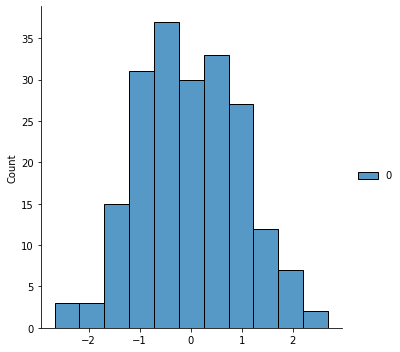

In [80]:
sns.displot(z_latent)

-2.6689055 2.687726


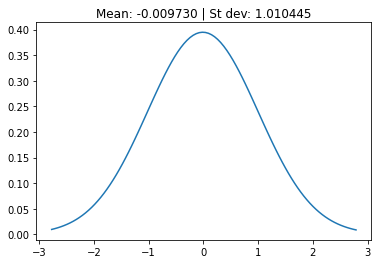

In [81]:
max_latent = np.max(z_latent)
min_latent = np.min(z_latent)
print(min_latent, max_latent)
x = np.linspace(min_latent-0.1, max_latent+0.1, 100)
mean_latent, std_latent = np.mean(z_latent), np.std(z_latent)
y = sp.stats.norm.pdf(x, mean_latent, std_latent)
plt.title('Mean: {:.6f} | St dev: {:.6f}'.format(mean_latent, std_latent))
plt.plot(x, y)
# plt.show()
# dist_sc

# Generate synthetic covariance matrices

## Test 1: encode and decode a matrix of the test set

(1, 31, 31, 1)


Text(0.5, 1.0, 'arbitrarty covset_test matrix DECODED')

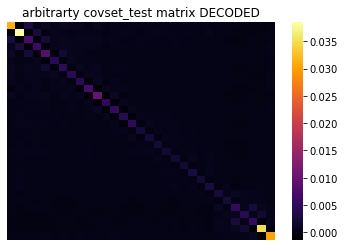

In [82]:
ztest1 = encoder.predict(covset[11].reshape((1,31,31)))

pred_matrix1 = decoder.predict(ztest1[2])
print(np.shape(pred_matrix1))
# pred_cov = pred_matrix[0, :, :nsize, 0]
pred_cov_sc1 = pred_matrix1[0, :, :nsize, 0]
pred_cov1 = pred_cov_sc1
# pred_cov1 = scalercov.inverse_transform(pred_cov_sc1)

sns.heatmap(pred_cov1, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('arbitrarty covset_test matrix DECODED')

## Test 3: Using syscov

In [59]:
ztest2 = encoder.predict(syscov_sc.reshape((1,31,31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
z_sample_syscov, mean_latent

(array([[-0.08666562]], dtype=float32), 0.01587544)

(1, 31, 31, 1)


Text(0.5, 1.0, 'using syscov')

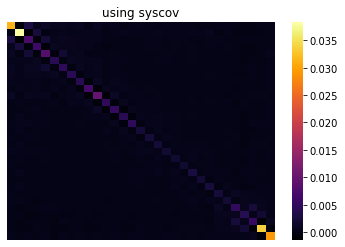

In [60]:
# pred_cov = pred_matrix[0, :, :nsize, 0]
pred_matrix2 = decoder.predict(ztest2[2])
print(np.shape(pred_matrix2))
pred_cov_sc2 = pred_matrix2[0, :, :nsize, 0]
# pred_cov2 = scalercov.inverse_transform(pred_cov_sc2)
pred_cov2 = pred_cov_sc2.reshape(31,31)


sns.heatmap(pd.DataFrame(pred_cov2), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('using syscov')

In [61]:
np.savetxt("fake_binned_JLA_COVdecodedTESTVAE2", pred_cov2, delimiter= " ", header="#fake COV")

## Test 3: With diagonal matrix and random noise

In [62]:
diagtest = np.diag(syscov_sc)
diagmat = np.zeros((31,31))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            diagmat[row, col] = diagtest[row]
        else:
            diagmat[row, col] = np.random.rand()*10**orderMag(covset[0,:,:][row, col])
ztest3 = encoder.predict(diagmat.reshape((1,31,31)))
ztest3


[array([[0.06682233]], dtype=float32),
 array([[0.11807925]], dtype=float32),
 array([[0.51691]], dtype=float32)]

(1, 31, 31, 1)


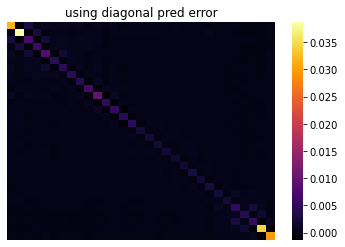

In [63]:
pred_matrix3 = decoder.predict(ztest3[2])
print(np.shape(pred_matrix3))
# pred_cov = pred_matrix[0, :, :nsize, 0]
pred_cov_sc3 = pred_matrix3[0, :, :nsize, 0]
pred_cov3 = pred_cov_sc3.reshape(31,31)
# pred_cov3 = scalercov.inverse_transform(pred_cov_sc3)

sns.heatmap(pd.DataFrame(pred_cov3), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title("using diagonal pred error")

np.savetxt("fake_binned_JLA_COVdecodedTESTVAE2", pred_cov3, delimiter= " ", header="#fake COV")

## Test 4: with the most probable sample of the latent space

<AxesSubplot:>

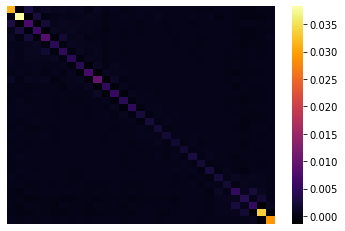

In [64]:
matrix4 = decoder.predict(np.array([mean_latent]))
# matrix4r = scalercov.inverse_transform(matrix4.reshape(31,31))
matrix4r = matrix4.reshape(31,31)
# matrix4r = matrix4r@D@matrix4r.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(matrix4r), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

# Test with new data. Distance modulus from another FFNN

In [65]:
# ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5')
# ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


# # ranz = z_redshift
# ranz = z_redshift + 0.001*np.random.randn()

# index = np.argsort(ranz)

# pred_random = ffnn.predict(np.log(ranz))
# pred_dl = pred_random[:,0].reshape(-1,1)

# pred_dl_sc = pred_dl.reshape(31,)[index]
# pred_err = np.exp(pred_random[:,1][index].reshape(-1,1))
# dlfake = scalerdist.inverse_transform(pred_dl_sc)

# fake_data = np.stack((ranz[index], dlfake[index]), axis=1)

# np.savetxt("fake_binned_JLA2TEST3.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

array([32.72378921, 33.1379776 , 33.54676056, 33.95006561, 34.34883499,
       34.74382019, 35.13565063, 35.52483368, 35.91179657, 36.29689407,
       36.68041229, 37.062603  , 37.44367218, 37.82379532, 38.20310974,
       38.58174896, 38.95980835, 39.33737946, 39.71453857, 40.09223175,
       40.47688293, 40.85940552, 41.29525757, 41.69662476, 42.10967636,
       42.50671387, 42.91246033, 43.33065796, 43.92466736, 44.53765869,
       44.7822876 ])

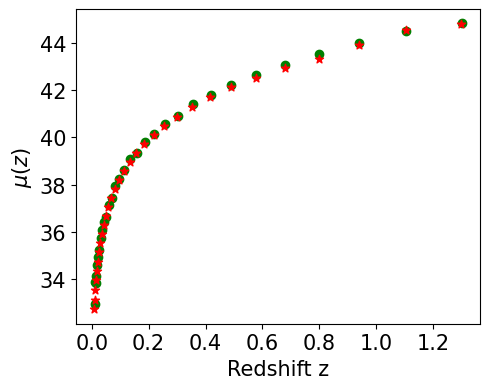

In [66]:
data = np.loadtxt("fake_binned_JLA2TEST3new.dat")
ranz = data[:,0]
dlfake = data[:,1]
plt.figure(figsize=(5,4), dpi=100)
# plt.errorbar(ranz, pred_random, yerr=0, fmt='r.', markersize=10.)
# plt.scatter(z, dl)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(ranz, dlfake, c='r', label='Synthetic data', marker='*')


# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
dlfake

In [67]:
# pred_dl
mean_ref = np.mean(dist)
std_ref = np.std(dist)
mean_pred = np.mean(dlfake)
std_pred = np.std(dlfake)
delta_mean = z_mean_syscov - mean_ref


mean_ref, delta_mean, z_mean_syscov

(38.762822546580644,
 array([[-38.68646]], dtype=float32),
 array([[0.07636327]], dtype=float32))

# Mapping in the gaussian of the latent space

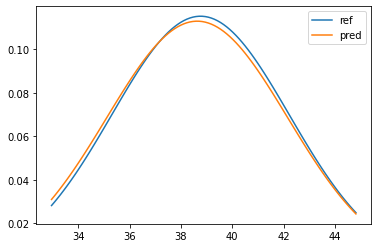

In [68]:
# plt.hist(pred_dl_sc, label='predictions') 
# plt.hist(dist_sc)#, normed=True)
# xmin, xmax = plt.xlim()
xmin = np.min(dist)
xmax= np.max(dist)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)


# x = np.linspace(xmin, xmax, 100)
y2 = sp.stats.norm.pdf(x, mean_pred, std_pred)
plt.plot(x, y1, label='ref')
plt.plot(x, y2, label='pred')

# plt.show()
# dist_sc
plt.legend()

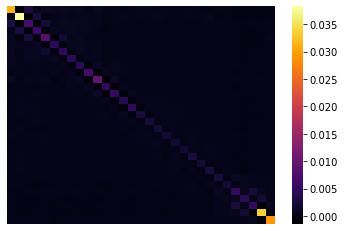

In [69]:
z_sample = np.array([mean_pred+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", newmatrixr, delimiter= " ", header="#fake COV")

In [70]:
diagerr = np.zeros((31,31))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            diagerr[row, col] = pred_err[row]
        else:
            diagerr[row, col] = np.random.rand()*10**orderMag(syscov[row, col])

diagerr = scalercov.transform(diagerr)            
ztest4 = encoder.predict(diagerr.reshape((1,31,31)))
ztest4

NameError: name 'pred_err' is not defined

In [ ]:
# z_sample = np.array([[0.0, 0.004]])
newmatrix = decoder.predict(ztest4[2])

In [ ]:
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31)@D@newmatrix.reshape(31,31).T)
newmatrixr = newmatrix.reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [ ]:
# np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", newmatrixr, delimiter= " ", header="#fake COV")

In [ ]:
# tf.keras.models.save_model(vae, '../models/convae.h5')
# tf.keras.models.save_model(encoder, '../models/convae_enc.h5')
# tf.keras.models.save_model(decoder, '../models/convae_dec.h5')

In [ ]:
vae.save_weights('vae_weights', save_format='tf')

# loaded_model = ClassifierModel(parameter)
# loaded_model.compile(parameters)
# loaded_model.train_on_batch(x_train[:1], y_train[:1])
# loaded_model.load_weights('model_weights')

# Nearest matrix

In [ ]:
from scipy import spatial

In [ ]:
diagmat_err = np.zeros((31,31))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            diagmat_err[row, col] = pred_err[row]

diagmat_err = scalercov.transform(diagmat_err)
diagmat_err = np.diag(diagmat_err)
diagmat_err

In [ ]:
diags = [np.diag(matrix) for matrix in covset]
tree = spatial.KDTree(diags)
distance, index = tree.query(diagmat_err)
distance, index 

In [ ]:
diagmat_err = np.zeros((31,31))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            diagmat_err[row, col] = pred_err[row]
#             diagmat_err[row, col] = syscov[row, col]
        else:
            diagmat_err[row, col] = covset[index, row, col]

In [ ]:
ztest = encoder.predict(covset[index].reshape((1,31,31)))

pred_matrixd = decoder.predict(ztest[2])
# pred_cov = pred_matrix[0, :, :nsize, 0]
pred_cov_sc = pred_matrixd[0, :, :nsize, 0]

pred_cov = pred_cov_sc.reshape(nsize, nsize)
# pred_cov = scalercov.inverse_transform(pred_cov_sc)
# pred_cov = pred_cov_sc@D@pred_cov_sc.T

sns.heatmap(pd.DataFrame(pred_cov), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('nearest covset_test matrix DECODED')

In [ ]:
np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", pred_cov, delimiter= " ", header="#fake COV")